In [2]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, plot_image, plot_images

In [7]:
# root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets/'
root_dir = '/data2/jupiter/datasets/'
# dataset = 'Jupiter_train_v6_2'
# dataset = 'halo_rgb_stereo_train_v8_1'
dataset = '20240312_2_million_for_model_positive_pipeline_part_0_stereo'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_stereo'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_labeled'
# dataset = 'halo_potential_airborne_debris_from_train_6_2_labeled'
# dataset = 'halo_potential_birds_from_train_8_1'
# csv = os.path.join(root_dir, dataset, 'annotations.csv')
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
# csv = os.path.join(root_dir, dataset, 'master_annotations_cleaned_20240329_50k.csv')
# csv = os.path.join(root_dir, dataset, 'master_annotations_cleaned_20240329_okaudit.csv')
# csv = os.path.join(root_dir, dataset, 'master_annotations_cleaned_20240329_50k_rev1_rev2_lying_down_sitting.csv')
# csv = os.path.join(root_dir, dataset, 'master_annotations_no_underexposed_peaty.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (3,16,20,21,22,23,24,26,27,29,30,31,32,33,34,35,36,37,102,103,128,135) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(294015, 191)

## Show image

In [8]:
len(df.unique_id.unique()), len(df.id.unique())

(294015, 204508)

In [11]:
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/20676_r2_rgb_bigdecay_biglr/halo_rgb_stereo_sample_train_2000'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/20676_r2_rgb_bigdecay_biglr/halo_rgb_stereo_test_v6_1'
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v81_nextvitsmall_dust_only_kore_dean_0406/20240312_2_million_for_model_positive_pipeline_part_0_stereo'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_wirev1_6cls_bin_cat_0123/20240312_2_million_for_model_positive_pipeline_part_0_stereo'
# pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_wirev1_6cls_bin_cat_0123/halo_potential_birds_from_train_8_1'
pred_df = pd.read_csv(os.path.join(pred_dir, 'output.csv'))
print(pred_df.shape)

df2 = df.merge(pred_df, on='unique_id')
# # df2 = df.merge(pred_df, on='unique_id')
# # df = df.merge(pred_df[['unique_id', 'state']], on='unique_id').merge(dust_df[['unique_id', 'gt_dust_ratio', 'total_averaged_dust_conf', 'total_thresholded_dust_ratio']], on='unique_id')
print(df2.shape)

(294015, 10)
(294015, 200)


In [10]:
pred_df.head(2)

,unique_id,result_state,result_human_state,result_vehicle_state,min_pixels_threshold,features,n_gt_human_pixels,gt_human_depth,n_pred_human_pixels,pred_human_depth
0,64d26ac23dc09b9126f6b4ce_T02_T03,true_negative,NaN,NaN,100,"{""large_object_pixels"": 32, ""large_object_min_...",0,1000,0,1000
1,64d293e4cdddad3864b84545_T02_T03,true_negative,NaN,NaN,100,"{""large_object_pixels"": 288, ""large_object_min...",0,1000,0,1000


In [14]:
df3 = df2[(df2.n_pred_human_pixels > 500) & (df2.n_pred_human_pixels < 1500)]
# df3 = df[((pred_df.birds > 0.5) | (pred_df.airborne > 0.5)) & (df.camera_location.str.startswith('T'))]
print(df3.shape)

(3601, 200)


In [33]:
# dfv62 = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_2_potential_airborne.csv')
# print(dfv62.shape)

# df4 = df3[~df3.id.isin(dfv62.id)]
# print(df4.shape)
# df4[['id']].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_1_potential_airborne_birds.csv', index=False)

(7270, 1)
(2159, 178)


64d6720c1cad24080c867dd0 T10


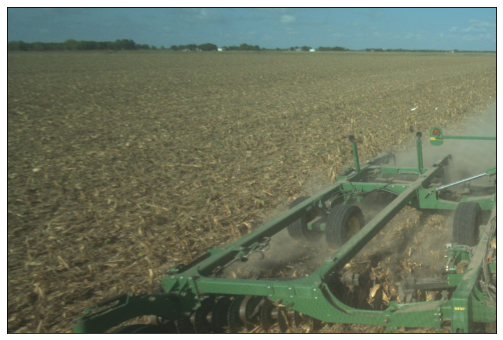

64d5deafd22763890d9c90a8 T01


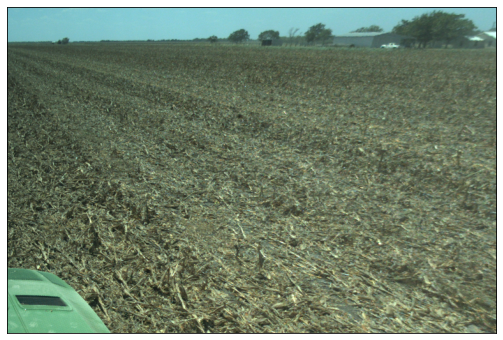

In [18]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
sub_df = df3.sample(2)
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = False, False
show_pred_result = False

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    print(row.id, row.camera_location)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label)

    if show_pred_result:
        result_path = os.path.join(pred_dir, 'output_visualization', row.id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

## Get categorical labels for training set

In [2]:
categorical_labels_map = {'objects': {'Utility pole', 'Immovable Objects', 'Buildings', 'Animals', 'Tile-Inlet'}, 'humans': {'Humans'}, 
                            'vehicles': {'Tractors or Vehicles'}, 'dust': {'Heavy Dust'}, 'birds': {'Birds'}, 'airborne': {'Airborne Debris'}}
cats = list(categorical_labels_map.keys())
categorical_object_labels = {v for k,vs in categorical_labels_map.items() for v in vs}
cats, categorical_object_labels

(['objects', 'humans', 'vehicles', 'dust', 'birds', 'airborne'],
 {'Airborne Debris',
  'Animals',
  'Birds',
  'Buildings',
  'Heavy Dust',
  'Humans',
  'Immovable Objects',
  'Tile-Inlet',
  'Tractors or Vehicles',
  'Utility pole'})

In [3]:
def get_categorical_labels(root_dir, dataset, row):
    label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
    labels = np.unique(label)
    label_map = row.label_map
    label_str_2_id = {label_map[str(i)]: i for i in labels if i != 0}
    # print(row.unique_id, label.shape, labels, label_str_2_id)
    # process object class
    for object_label, subs in categorical_labels_map.items():
        object_ids = [label_str_2_id[sub] for sub in subs if sub in label_str_2_id]
        object_pixel_count = 0
        if len(object_ids) > 0:
            object_pixel_count = np.count_nonzero(np.isin(label, object_ids))
        row[object_label] = object_pixel_count
    return row

# get_categorical_labels(root_dir, dataset, df.iloc[100])

In [44]:
# df = df.apply(lambda row: get_categorical_labels(root_dir, dataset, row), axis=1)
# print(df.shape)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_2/train_v6_2_birds_airborne_categorical_count.csv', index=False)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv', index=False)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_1_categorical_count.csv', index=False)

(16894, 430)


In [6]:
# count_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_2/train_v6_2_birds_airborne_categorical_count.csv')
# count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv')
count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_1_categorical_count.csv')
# count_df = df[['unique_id'] + cats]
print(count_df.shape)
count_df.head(2)

(50864, 7)


,unique_id,objects,humans,vehicles,dust,birds,airborne
0,64cfdb12ccc434d8f6bf9808_T01_T03,241,0,0,0,0,0
1,64cfdc6ae578ee9334a30426_T01_T03,17184,0,0,0,0,0


In [8]:
categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 50], ['airborne', 50]]
for cat, thres in categorical_labels:
    cat_count_df = count_df[count_df[cat] > thres]
    print(f'{cat}: # images {len(cat_count_df)}, {len(df) / len(cat_count_df):.1f}, quantile 90% pixel count {cat_count_df[cat].quantile(q=0.9):.0f}')
    # cat_count_df[cat].hist(bins=100)
    # plt.show()

objects: # images 38270, 1.3, quantile 90% pixel count 33235
humans: # images 16346, 3.1, quantile 90% pixel count 30092
vehicles: # images 8386, 6.1, quantile 90% pixel count 101172
dust: # images 4523, 11.2, quantile 90% pixel count 359313
birds: # images 1478, 34.4, quantile 90% pixel count 7009
airborne: # images 1923, 26.5, quantile 90% pixel count 5134


In [22]:
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
# seg_model = 'v61_7cls_dustaugonhuman_dlbase_0109'
seg_model = 'ds_v6_1_4x_human'
pred_df = pd.concat([pd.read_csv(f'{pred_dir}/{seg_model}/{dataset}_640/output.csv'), pd.read_csv(f'{pred_dir}/{seg_model}/{dataset}_768/output.csv')], ignore_index=True)
print(pred_df.shape)
pred_df.head(1)

(50864, 11)


,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,state,human_state,vehicle_state,min_pixels_threshold,features
0,64cfde4981c0f0db5eaa1f29_T02_T03,64cfde4981c0f0db5eaa1f29,T02,daytime,first headland pass,s3://blueriver-jupiter-data/continuous/halohit...,true_negative,NaN,NaN,50,"{""large_object_pixels"": 16, ""large_object_min_..."


In [19]:
def get_results(count_df, res_df, binary_category=True, only_2cls=True):
    print(f'category gt_count pred_count matched')
    if binary_category:
        if only_2cls:
            categorical_labels = [['birds', 25], ['airborne', 50]]
        else:
            categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 25], ['airborne', 50]]
        for cat, thres in categorical_labels:
            cat_count_df = count_df[count_df[cat] > thres]
            cat_res_df = res_df[res_df[cat] > 0.5]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))
    else:
        if only_2cls:
            categorical_labels = [['birds', 2256], ['airborne', 5477]]
        else:
            categorical_labels = [['objects', 24664], ['humans', 31081], ['vehicles', 131716], ['dust', 360000], ['birds', 2256], ['airborne', 5477]]
        percent_thres = 0.005
        for cat, thres in categorical_labels:
            cat_count_df = count_df[(count_df[cat] / thres) > percent_thres]
            cat_res_df = res_df[res_df[cat] > percent_thres]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))

In [23]:
run_ids = [
    # 'v61_6cls_cat_0119',
    # 'v61_6cls_cat_0120',
    'v61_6cls_posw_cat_0120',
    # 'v61_2cls_bin_cat_0122',
    'v61_wirev1_6cls_bin_cat_0123',
    # 'v61_6cls_np90_cat_0120',
    # 'v61_6cls_np90_posw_cat_0120',
    # 'v61_6cls_np90_cap_posw_cat_0120',
]
for run_id in run_ids:
    print(run_id)
    res_df = pd.read_csv(f'/data/jupiter/li.yu/exps/driveable_terrain_model/{run_id}/halo_rgb_stereo_test_v6_1/output.csv')
    get_results(count_df, res_df, binary_category = not 'np90' in run_id, only_2cls=False)
    print()

v61_6cls_posw_cat_0120
category gt_count pred_count matched
objects 38270 41483 35459
humans 16346 11955 11191
vehicles 8386 10113 5125
dust 4523 4843 3516
birds 1511 622 527
airborne 1923 2044 689

v61_wirev1_6cls_bin_cat_0123
category gt_count pred_count matched
objects 38270 41626 35837
humans 16346 15450 13823
vehicles 8386 12608 6478
dust 4523 5071 3722
birds 1511 1924 958
airborne 1923 1751 783



In [18]:
cat = 'birds'
cat_count_df = count_df[count_df[cat] > thres]
cat_res_df = res_df[res_df[cat] > 0.5]
cat_pred_df = pred_df[pred_df.state == 'true_positive']
cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
cat_pred_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_pred_df.unique_id)]
print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df), len(cat_pred_df), len(cat_pred_correct_df))

birds 1478 1924 949 5297 709


In [41]:
cat = 'airborne'
cat_count_df = count_df[count_df[cat] > thres]
cat_res_df = res_df[res_df[cat] > 0.5]
cat_rectify_df = pred_df[(pred_df.state == 'true_positive') | (pred_df.state == 'false_negative')]
cat_pred_df = pred_df[(pred_df.state == 'true_positive')]
cat_correct_df = cat_res_df[cat_res_df.unique_id.isin(cat_rectify_df.unique_id)]
cat_pred_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_pred_df.unique_id)]
print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df), len(cat_rectify_df), len(cat_pred_correct_df))

airborne 1923 1751 538 937 603


## Find and send images for labeling

In [33]:
# # prepare csv for running classifier
# # dataset = '20240119_halo_rgb_stereo'
# dataset = '20231219_halo_rgb_stereo'
# df2 = pd.read_csv(f'/data2/jupiter/datasets/{dataset}/annotations.csv')
# LEFT_CAMERAS = ['front-center-left', 'front-left-left', 'front-right-left', 'side-left-left', 'side-right-left', 'rear-left', 'T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14', 'I01', 'I02']
# df2_left = df2[df2.camera_location.isin(LEFT_CAMERAS)]
# print(df2.shape, df2_left.shape)
# df2_left.to_csv(f'/data2/jupiter/datasets/{dataset}/annotations_left.csv', index=False)

(356046, 149) (149573, 149)


In [42]:
def try_ast(x):
    try:
        return ast.literal_eval(x)
    except:
        return {}  
# load data df
root_dir = '/data2/jupiter/datasets/'
datasets = [
    # '20240119_halo_rgb_stereo',
    # '20231219_halo_rgb_stereo',
    'halo_potential_airborne_debris_from_train_6_2',
]
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval, "gps_can_data": ast.literal_eval}
df = pd.concat([pd.read_csv(f'{root_dir}/{dataset}/annotations.csv', converters=converters) for dataset in datasets], ignore_index=False)
df['bag_date'] = df['bag_name'].apply(lambda s: s[:10])
# # check exposure
# df['exposure_ms'] = df[['exposure_ms__json', 'camera_exposure_milliseconds_list__json']].apply(lambda x: try_ast(x['camera_exposure_milliseconds_list__json']) 
#     if x['camera_exposure_milliseconds_list__json'] is not None else try_ast(x['exposure_ms__json']), axis=1)
# df['short_exposure'] = df.exposure_ms.apply(lambda x: float(x[1]))
# df['long_exposure'] = df.exposure_ms.apply(lambda x: float(x[0]))
# df = df[~((df.operation_time == 'nightime') & (df.long_exposure.apply(lambda x: np.isclose(x, 1.6, rtol=1e-1, atol=1e-1))))]
df.shape

<ipython-input-42-0317233348cc>:14: DtypeWarning: Columns (8,22,56,57,62,64,74,77,78,86,103,108,109,111,113,116,117,129,163,164) have mixed types.Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f'{root_dir}/{dataset}/annotations.csv', converters=converters) for dataset in datasets], ignore_index=False)


(184857, 169)

In [22]:
# load pred df
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_wirev1_6cls_bin_cat_0123'
res_df = pd.concat([pd.read_csv(f'{pred_dir}/{dataset}/output.csv') for dataset in datasets], ignore_index=False)
cat = 'airborne'
cat_res_df = res_df[res_df[cat] > 0.5]
res_df.shape, cat_res_df.shape

((184857, 7), (11364, 7))

In [25]:
cat_df = df[df.id.isin(cat_res_df.unique_id)]
print(cat_df.shape)
LEFT_CAMERAS = ('T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14')
cat_df = cat_df[cat_df.camera_location.isin(LEFT_CAMERAS)]
print(cat_df.shape)

(11364, 169)
(7287, 169)


In [50]:
cat_df[['id']].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_2_potential_airborne.csv', index=False)

In [46]:
import sys
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')

import os
os.environ["BRT_ENV"] = 'prod'
import json
import random
import brtdevkit
print(brtdevkit.__version__)
brtdevkit.log = 'info'
import os
os.environ['AWS_PROFILE'] = 'default'

import time
import numpy as np
import pandas as pd
from datetime import datetime, timezone

from brtdevkit.core.db.athena import AthenaClient, Table
from brtdevkit.data import Image, Dataset

Internal AWS credentials have been removed from brt-devkit.
To setup AWS credentials, Please follow instructions at : https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html


7.4.3


In [47]:
test_df1 = Dataset.retrieve(name='20231016_halo_rgb_passve_hh_model_positives_pruned_to_label').to_dataframe()
test_df2 = Dataset.retrieve(name='halo_sample_unlabeled_humans_v19_to_label_active_hh').to_dataframe()
test_df1.shape, test_df2.shape

((3937, 153), (147743, 157))

In [49]:
cat_df = cat_df[~cat_df.id.isin(test_df1.id)]
cat_df = cat_df[~cat_df.id.isin(test_df2.id)]
cat_df.shape

(7270, 169)

In [51]:
cat_df.groupby('operation_time').count()

,actor,actor_clothing,artifact_debayeredrgb_0__id,artifact_debayeredrgb_0_content_hash,artifact_debayeredrgb_0_created_at,artifact_debayeredrgb_0_data_category,artifact_debayeredrgb_0_id,artifact_debayeredrgb_0_image,artifact_debayeredrgb_0_is_archived,artifact_debayeredrgb_0_kind,...,vpu2,vpu_position,was_compressed,water,water_management,weather,weather_summary,weeds,artifact_debayeredrgb_0_save_path,bag_date
operation_time,,,,,,,,,,,,,,,,,,,,,
dawn_dusk,150,152,425,425,425,425,425,425,0,425,...,306,425,425,219,17,17,425,219,425,425
daytime,67,87,1516,1516,1516,1516,1516,1516,4,1516,...,1200,1516,1516,121,332,332,1516,121,1516,1516
nightime,401,658,5297,5297,5297,5297,5297,5297,9,5297,...,4867,5297,5297,979,425,425,5297,979,5297,5297
unknown,32,32,32,32,32,32,32,32,0,32,...,32,32,32,32,0,0,32,32,32,32


## Prune by geohash and already sent images

In [43]:
# load already labeled csv
already_labeled_csv_dir = '/data/jupiter/li.yu/data/halo_hard_cases'
already_labeled = [
    '20231206_20231219_sent_for_labeling.csv'
]
already_df = pd.concat([pd.read_csv(os.path.join(already_labeled_csv_dir, a)) for a in already_labeled], ignore_index=True)
print(already_df.shape, 'unique_id' in already_df)

<ipython-input-43-193255fbfb7c>:5: DtypeWarning: Columns (29,56,71,72,73,74,77,146,148,149,151,152,153,154,155,156,157,158,159,160,161) have mixed types.Specify dtype option on import or set low_memory=False.
  already_df = pd.concat([pd.read_csv(os.path.join(already_labeled_csv_dir, a)) for a in already_labeled], ignore_index=True)


(63419, 162) False


In [55]:
# prune by already labeled images
cat_df = cat_df[~cat_df.id.isin(already_df.id)]
cat_df.shape

(10181, 154)

In [57]:
# clean data with bad metadata
cat_df = cat_df[~cat_df["gps_can_data"].isna()]
print(cat_df.shape)

# get required metadata
geohash_length = 7 # 150x150 meters
cat_df['geohash_short'] = cat_df.geohash.apply(lambda x: x[:geohash_length])
cat_df['collected_on_datetime'] = pd.to_datetime(cat_df.collected_on)
# cat_df['calibration_data'] = cat_df.calibration_data__json.apply(lambda x: get_calibration(x))
# cat_df['exposure_ms'] = cat_df.calibration_data.apply(lambda x: x.get('exposure_ms', '-1'))
# cat_df['short_exposure'] = cat_df.exposure_ms.apply(lambda x: float(x[1]))
cat_df['identifier'] = cat_df.apply(lambda x: x['geohash'] + '_' + x['camera_location'], axis=1)
cat_df['speed'] = cat_df['gps_can_data'].apply(lambda x: x.get('speed', np.nan))
print(cat_df.shape)

(10181, 154)
(10181, 158)


In [68]:
# filter by geohash short so that each geohash contains limited number of samples
cat_df["geohash_6"] = cat_df["geohash"].apply(lambda x: x[:6])
total_geo_counts = cat_df["geohash_6"].value_counts()
geohash_6_limit = 500
new_cat_dfs = []
for geohash_6 in total_geo_counts.index:
    geohash_6_df = cat_df[cat_df["geohash_6"] == geohash_6]
    if len(geohash_6_df) > geohash_6_limit:
        geohash_6_df = geohash_6_df.sample(geohash_6_limit)
    new_cat_dfs.append(geohash_6_df)
new_cat_df = pd.concat(new_cat_dfs, ignore_index=True)
new_cat_df.shape

(5917, 159)

In [71]:
# filter to be only train or test geohashes
geohash_table = pd.read_csv(
    f"{already_labeled_csv_dir}/20240124_geohash_table_v6_2.csv", # most recent version
    index_col="Unnamed: 0"
)

print(geohash_table.shape)
geohash_table.head()

(2061, 1)


,bucket
9xjg3r,train
dp4ux2,buffer
dp4urp,buffer
dp4uqz,buffer
dp4ux8,test


In [82]:
final_cat_df = new_cat_df[new_cat_df.geohash_6.isin(geohash_table[geohash_table["bucket"] != "buffer"].index)]
print(final_cat_df.shape)
final_cat_df.to_csv(f'{already_labeled_csv_dir}/20231219_20240119_halo_rgb_left_airborne.csv', index=False)

(5903, 159)


## Search around airborne debris images in training set to add more such data

In [29]:
df[['unique_id', 'has_airborne']].groupby('has_airborne').count()

,unique_id
has_airborne,
False,267657
True,12907


In [30]:
ab_df = df[df.has_airborne == True]
print(ab_df.shape, ab_df.iloc[0].geohash)

(12907, 348) 9xjgd16r9gj0


In [31]:
ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])
total_geo_counts = ab_df["geohash_6"].value_counts()
print(total_geo_counts.shape)

(558,)


<ipython-input-31-10d40a88c582>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])


In [32]:
total_geo_counts.head(4)

dp03k2    504
dp03hp    461
dp03k3    382
dp03k6    297
Name: geohash_6, dtype: int64

In [33]:
ab_df[ab_df.geohash_6 == 'dp03k2'][['unique_id', 'collected_on_day']].groupby('collected_on_day').count()

,unique_id
collected_on_day,
2023-09-11 00:00:00.000,90
2023-09-12 00:00:00.000,370
2023-09-13 00:00:00.000,43
2023-09-14 00:00:00.000,1


In [40]:
geohash_6_limit = 500
geohash_6_expand = 1.5
surround_ids = 0
for geohash_6 in ab_df.geohash_6.unique():
    collected_on_days = ab_df[(ab_df.geohash_6 == geohash_6)].collected_on_day.unique()
    for collected_on_day in collected_on_days:
        current = len(ab_df[(ab_df.geohash_6 == geohash_6) & (ab_df.collected_on_day == collected_on_day)].unique_id.unique())
        expand = int(geohash_6_limit / current * geohash_6_expand)
        if expand < 50:
            expand = 50
        elif expand > 500:
            expand = 500
        surround_ids += expand
        # # check how many images actually contain airborne debris
        # sub_df = cat_df[(cat_df.geohash.str.startswith(geohash_6)) & (cat_df.collected_on.str.startswith(collected_on_day[:10]))]
        # if len(sub_df) > 0:
        #     print(geohash_6, collected_on_day, expand, len(sub_df))
surround_ids

187650

In [58]:
ab_df[(ab_df.geohash_6 == '9zpuut') & (ab_df.hard_drive_name == 'JUPD-156_2023-10-23')][['unique_id', 'collected_on_day']].groupby('collected_on_day').count()

,unique_id
collected_on_day,
2023-11-03 00:00:00.000,18
2023-11-04 00:00:00.000,1
2023-11-05 00:00:00.000,10
2023-11-06 00:00:00.000,18
2023-11-07 00:00:00.000,3


## Search around birds images in training set to add more such data

In [74]:
df['Birds'] = df['label_counts'].apply(lambda d: d.get('Birds', 0))
df['has_birds'] = df['Birds'] > 0

df[['unique_id', 'has_birds']].groupby('has_birds').count()

,unique_id
has_birds,
False,325509
True,1362


In [75]:
bird_df = df[df.has_birds == True]
print(bird_df.shape, bird_df.iloc[0].geohash)

(1362, 361) 9xjg9cde9btm


In [77]:
bird_df["geohash_6"] = bird_df["geohash"].apply(lambda x: x[:6])
total_geo_counts = bird_df["geohash_6"].value_counts()
print(total_geo_counts.shape)

total_geo_counts.head(4)

(158,)


<ipython-input-77-ec8026b0bcdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_df["geohash_6"] = bird_df["geohash"].apply(lambda x: x[:6])


9z1pgk    232
9v5ks7    153
9z1pg7    113
9ufs6w    105
Name: geohash_6, dtype: int64

In [79]:
bird_df[bird_df.geohash_6 == '9z1pgk'][['unique_id', 'collected_on_day']].groupby('collected_on_day').count()

,unique_id
collected_on_day,
2024-03-13,232


In [80]:
geohash_6_limit = 500
geohash_6_expand = 1.5
surround_ids = 0
for geohash_6 in bird_df.geohash_6.unique():
    collected_on_days = bird_df[(bird_df.geohash_6 == geohash_6)].collected_on_day.unique()
    for collected_on_day in collected_on_days:
        current = len(bird_df[(bird_df.geohash_6 == geohash_6) & (bird_df.collected_on_day == collected_on_day)].unique_id.unique())
        expand = int(geohash_6_limit / current * geohash_6_expand)
        if expand < 50:
            expand = 50
        elif expand > 500:
            expand = 500
        surround_ids += expand
        # # check how many images actually contain airborne debris
        # sub_df = cat_df[(cat_df.geohash.str.startswith(geohash_6)) & (cat_df.collected_on.str.startswith(collected_on_day[:10]))]
        # if len(sub_df) > 0:
        #     print(geohash_6, collected_on_day, expand, len(sub_df))
surround_ids

60792

## Debug cutnpaste presampling

In [22]:
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')
from dl.dataset.cutnpaste_presampling import pre_sampling_for_cutnpaste

In [19]:
print(c2)

['brightness', 'label_counts', 'Airborne-debris', 'Driveable', 'humans_pixel_count', 'humans_max_row', 'humans_min_row', 'humans_max_col', 'humans_min_col', 'is_multi_human', 'is_standing_human', 'is_laying_down_human', 'occluded_humans', 'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row', 'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col', 'tractors_or_vehicles_min_col', 'unique_id']


In [23]:
cutnpaste_aug_params = {    
    'humans': {'blend_mode': 'vanilla', 'brightness_range': 0.05, 'cutout_rate': 0.5, 'depth_aware': False,
      'jitter_object': False, 'jitter_range': 0.15, 'laying_down_max_pixels': 15000, 'laying_down_min_pixels': 50,
      'max_cutout': 0.6, 'max_pixels': 1000000, 'min_pixels': 20, 'only_non_occluded': True,
      'rotate_degree': 30, 'rotate_object': True, 'same_brightness': True, 'same_operation_time': False,
      'sample_ratio': 0.4, 'standing_max_pixels': 100000, 'standing_min_pixels': 20, 'use_laying_down_human': True,
      'use_multi_human': True, 'use_standing_human': True},
}
outer = {    
    'preparer': {
      'classes': ['Humans', 'Tractors or Vehicles'],
      'human_non_standing_aspect_ratio_threshold': 0.5,
      'load_from_aug_csv': '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_1_80k_cutnpaste.csv',
      'num_cutnpaste_samples': 150,
      'num_workers': 16,
      'save_to_aug_csv': '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_1_80k_cutnpaste.csv'},
    'use': True,
    'vehicles': {'blend_mode': 'vanilla', 'brightness_range': 0.05, 'cutout_rate': 0.0, 'depth_aware': False,
      'jitter_object': False, 'jitter_range': 0.15, 'max_cutout': 0.6, 'max_pixels': 1000000,
      'min_pixels': 20, 'only_non_occluded': True, 'rotate_degree': 30, 'rotate_object': True,
      'same_brightness': True, 'same_operation_time': False, 'sample_ratio': 0.25},
}

dataframe_cnp = pre_sampling_for_cutnpaste(
    df,
    cutnpaste_aug_params,
    k_fixed_samples=100,
    num_workers=4,
    cache_dir='/data2/jupiter/datasets/halo_rgb_stereo_train_v8_1',
)
dataframe_cnp.shape

In [6]:
df[['unique_id', 'rectified_stereo_output_width']].groupby('rectified_stereo_output_width').count()

,unique_id
rectified_stereo_output_width,
640,116512
768,208971


In [4]:
# df['unique_id_len'] = df['unique_id'].apply(lambda s: len(s))
gdf = df[df.rectified_stereo_output_width > 0]
bdf = df[~df.unique_id.isin(gdf.unique_id)]
gdf.shape, bdf.shape

((325483, 393), (0, 393))

In [61]:
bdf['unique_id_len'] = bdf['unique_id'].apply(lambda s: len(s))

In [54]:
bdf = df[~df.unique_id.isin(gdf.unique_id)]

In [60]:
bdf[['unique_id', 'rectified_stereo_output_width', 'camera_location', 'camera_location_right']]

,unique_id,rectified_stereo_output_width,camera_location,camera_location_right
325927,617bc59766af5962349ef679,NaN,front-center-left,NaN
325928,6171b92bac1e069b248708fb,NaN,side-right-left,NaN
325929,61c43d42a11c7feb8256d642,NaN,side-left-left,NaN
325930,61c43643909d1e70f764a90c,NaN,rear-left,NaN
325931,61344883574551f3f04529ca,NaN,front-left-left,NaN
...,...,...,...,...
345768,611c62ebe7dbf9dc3e4e0f3d,NaN,front-right-left,NaN
345769,61c2b6ba7edfc3149e4326e4,NaN,rear-left,NaN
345770,61e2663ec8f15657a285c831,NaN,side-right-left,NaN
345771,6152e22932272a54ed9ff97a,NaN,front-right-left,NaN


In [64]:
df.loc[df.rectified_stereo_output_width.isna(), "rectified_stereo_output_width"] = 1024
df.loc[df.camera_location_right.isna(), "camera_location_right"] = bdf.camera_location.apply(lambda s: s[:-4]+'right')
df.to_csv(csv, index=False)